In [1]:
from eda_helpers import *
import warnings
from heapq import nlargest
import pandas as pd
from copy import deepcopy

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
train_eda = EDA()
val_eda = EDA()

train_sentences, val_sentences, train_entities, val_entities = load_data("./train.txt")

train_eda.compute_word_entity_eda(train_sentences, train_entities)
TRAIN_SENT_EDA_INFO  = train_eda.compute_sentence_eda(train_sentences, train_entities)

val_eda.compute_word_entity_eda(val_sentences, val_entities)
VAL_SENT_EDA_INFO = val_eda.compute_sentence_eda(val_sentences, val_entities)

Count of O in whole data is 47539 so random probability of being a token as O is: 0.95
Count of B-person in whole data is 513 so random probability of being a token as B-person is: 0.01
Count of B-location in whole data is 436 so random probability of being a token as B-location is: 0.009
Count of I-person in whole data is 244 so random probability of being a token as I-person is: 0.005
Count of I-location in whole data is 200 so random probability of being a token as I-location is: 0.004
Count of B-group in whole data is 196 so random probability of being a token as B-group is: 0.004
Count of B-corporation in whole data is 185 so random probability of being a token as B-corporation is: 0.004
Count of I-creative-work in whole data is 169 so random probability of being a token as I-creative-work is: 0.003
Count of I-product in whole data is 161 so random probability of being a token as I-product is: 0.003
Count of I-group in whole data is 122 so random probability of being a token as I-

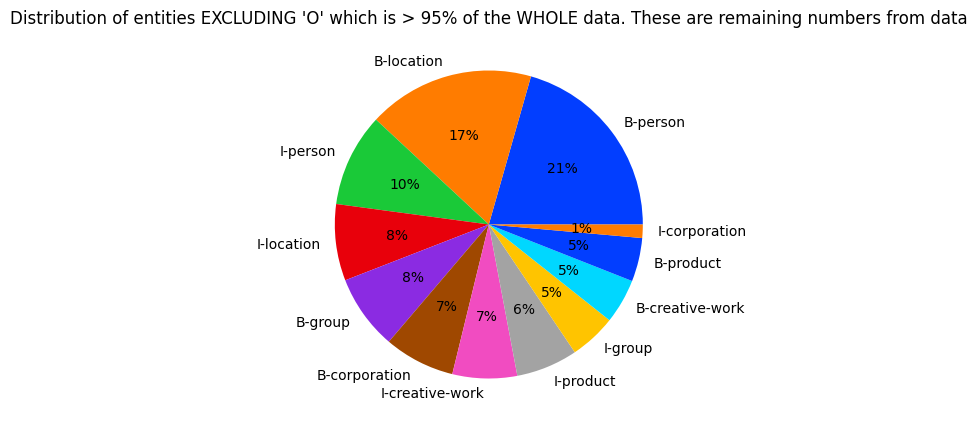

In [3]:
fig = plt.figure(figsize = (20,5))
data = []
labels = []

total_count = sum(train_eda.unique_entities.values())
random_tag_probabilities = {tag: count / total_count for tag, count in train_eda.unique_entities.items()}


sorted_dict = sorted(train_eda.unique_entities.items(), key = lambda x: x[1], reverse = True)
for i in sorted_dict:
    print(f"Count of {i[0]} in whole data is {i[1]} so random probability of being a token as {i[0]} is: {round(random_tag_probabilities[i[0]], 3)}")
    
    if i[0] == "O":continue
    labels.append(i[0])
    data.append(i[1])


plt.pie(data, labels = labels, colors = sns.color_palette('bright'), autopct='%.0f%%')
plt.title("Distribution of entities EXCLUDING 'O' which is > 95% of the WHOLE data. These are remaining numbers from data")
plt.show()

Random Probabilities for the full Class based on data:
{'O': 0.95, 'person': 0.015, 'location': 0.013, 'creative-work': 0.006, 'group': 0.006, 'corporation': 0.004, 'product': 0.005}


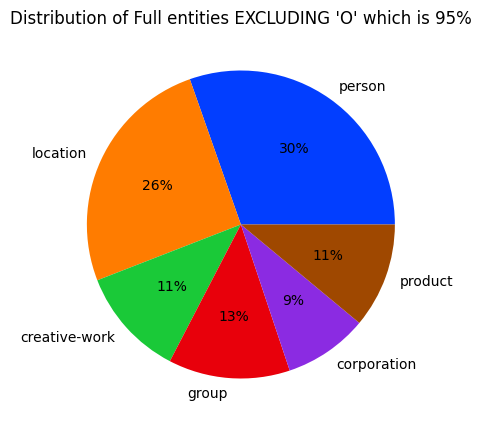

In [4]:
whole_ent = {}
for key,value in train_eda.unique_entities.items():
    if key != "O":
        new_key = key[2:]
    else: new_key = key

    if new_key not in whole_ent: whole_ent[new_key] = value
    else: whole_ent[new_key] += value



total_count = sum(whole_ent.values())
random_full_tag_probabilities = {tag: round(count / total_count, 3) for tag, count in whole_ent.items()}
print("Random Probabilities for the full Class based on data:")
print(random_full_tag_probabilities)

del whole_ent["O"]

fig = plt.figure(figsize = (20,5))
plt.pie(whole_ent.values(), labels = whole_ent.keys(), colors = sns.color_palette('bright'), autopct='%.0f%%')
plt.title("Distribution of Full entities EXCLUDING 'O' which is 95%")
plt.show()

**`I-Creative > B-Creative` and similarly `I-Product > B-Product`** so it either means that there is issue with `Creative Work` & `Product` tagging or these two types have 2+ tokens on an average 

## Anomalies and Label Sanity Checking

In [5]:
# Sanity check for labels if all I-TAG follow it's B-Tag and there is no other tag in between except same I-TAG
for lis in train_entities:
    if not sanity_check_entities(lis):print(lis)

In [6]:
print("Suspected Anomalies")

D = {"Numbers": train_eda.nums, "Non - Alpha Numeric":train_eda.not_alnum, "Non - Ascii":train_eda.non_ascii, "Links":train_eda.links,"Hashtags":train_eda.hashtags}
for anomaly_name, dic in D.items():
    print("\n")
    print("*"*50)

    parent_dic = deepcopy(dic) # uncomment the below and comment this one for high level overview
    # parent_dic = build_parent_level_dict(dic)

    if "O" in parent_dic: del parent_dic["O"]
    if len(parent_dic):
        print("\n")
        print(f"Suspected Anomaly Type: {anomaly_name}")

    for ent_name, val in parent_dic.items():
            print("\n")
            print("-"*15, ent_name, "-"*15, "\n")

            for word, sent_index, word_index in val:
                print(f"Word: '{word}' labelled as {train_entities[sent_index][word_index]} at example index {sent_index}")

Suspected Anomalies


**************************************************


Suspected Anomaly Type: Numbers


--------------- I-product --------------- 

Word: '11' labelled as I-product at example index 156
Word: '360' labelled as I-product at example index 170
Word: '360' labelled as I-product at example index 290
Word: '25' labelled as I-product at example index 448
Word: '21' labelled as I-product at example index 1163
Word: '2' labelled as I-product at example index 1163
Word: '4' labelled as I-product at example index 1263
Word: '8' labelled as I-product at example index 1263
Word: '501' labelled as I-product at example index 1582
Word: '9556' labelled as I-product at example index 1638
Word: '2008' labelled as I-product at example index 1668
Word: '2008' labelled as I-product at example index 1668
Word: '4' labelled as I-product at example index 2005
Word: '4' labelled as I-product at example index 2668


--------------- I-group --------------- 

Word: '5' labelled as I-group at 

# Sentece Level EDA or Training data (80% of `train.txt`)
1. Approx **237** unique contractions present satisfying `char'char` + Lowercasse + 0 space. 
2. Approx **1417** unique mentions satisfying `@char` with hight being `Justinbieber` being mentioned 14 times. Data labelling issue is there as a lot of them are used ad out entity tags
3. Approx **587** unique Hashtags present satisfying `#a1`. A lot of them are tagged throught different categories
4. 0 **Non ASCII** Chracters present it means that during tokenizations accents must have been removed already or converted to ASCII counterpart. So without having original data, can't do anything
5. Length of Sentences without space and No of tokens in both train and val are almost perfectly normally distributed with a max token of *41* and Max sentence length of *141*. This helps a lot in setting the ***MAX_LEN*** param in Deep learning models
6. There is a significant no of `Title` and `UPPER` case tokens in data. It either represents an abbreviation or Slang (Upper) or mostly a name, Loc, Company etc (Title). If we include the entity info here, it represents a lot of them are entities so a `CASED` model did better in practice than the `UNCASED` one
7. More than `63%` of the whole sentences are there where None of the given entities are present except `O` but dropping them created information scaracity in the dataset limiting the no of examples

In [7]:
print(sorted(Counter([i.lower().replace(" ","") for i in train_eda.hashtags_s]).items(), key = lambda x: x[1], reverse = True)[:9])

[('#ff', 18), ('#nowplaying', 7), ('#zodiacfacts', 7), ('#deals', 7), ('#blackholidays', 4), ('#reallymeans', 4), ('#itstheteenlife', 3), ('#twitter', 3), ('#twittertime', 3)]


In [8]:
print(sorted(Counter([i.lower().replace(" ","") for i in train_eda.mentions]).items(), key = lambda x: x[1], reverse = True)[:9])

[('@justinbieber', 14), ('@null', 14), ('@souljaboy', 6), ('@zodiacfacts', 6), ('@youtube', 6), ('@itstheteenlife', 5), ('@wakaflocka1017', 5), ('@lightcms', 5), ('@jday_sept15', 5)]


In [9]:
print(sorted(Counter([i.lower().replace(" ","") for i in train_eda.contractions]).items(), key = lambda x: x[1], reverse = True)[:9])

[("i'm", 158), ("it's", 111), ("don't", 56), ("i'll", 36), ("can't", 36), ("i've", 35), ("that's", 29), ("you're", 28), ("n't", 26)]


In [10]:
print(sorted(Counter([i.lower().replace(" ","") for i in train_eda.contractions]).items(), key = lambda x: x[1], reverse = True)[:9])

[("i'm", 158), ("it's", 111), ("don't", 56), ("i'll", 36), ("can't", 36), ("i've", 35), ("that's", 29), ("you're", 28), ("n't", 26)]


[]

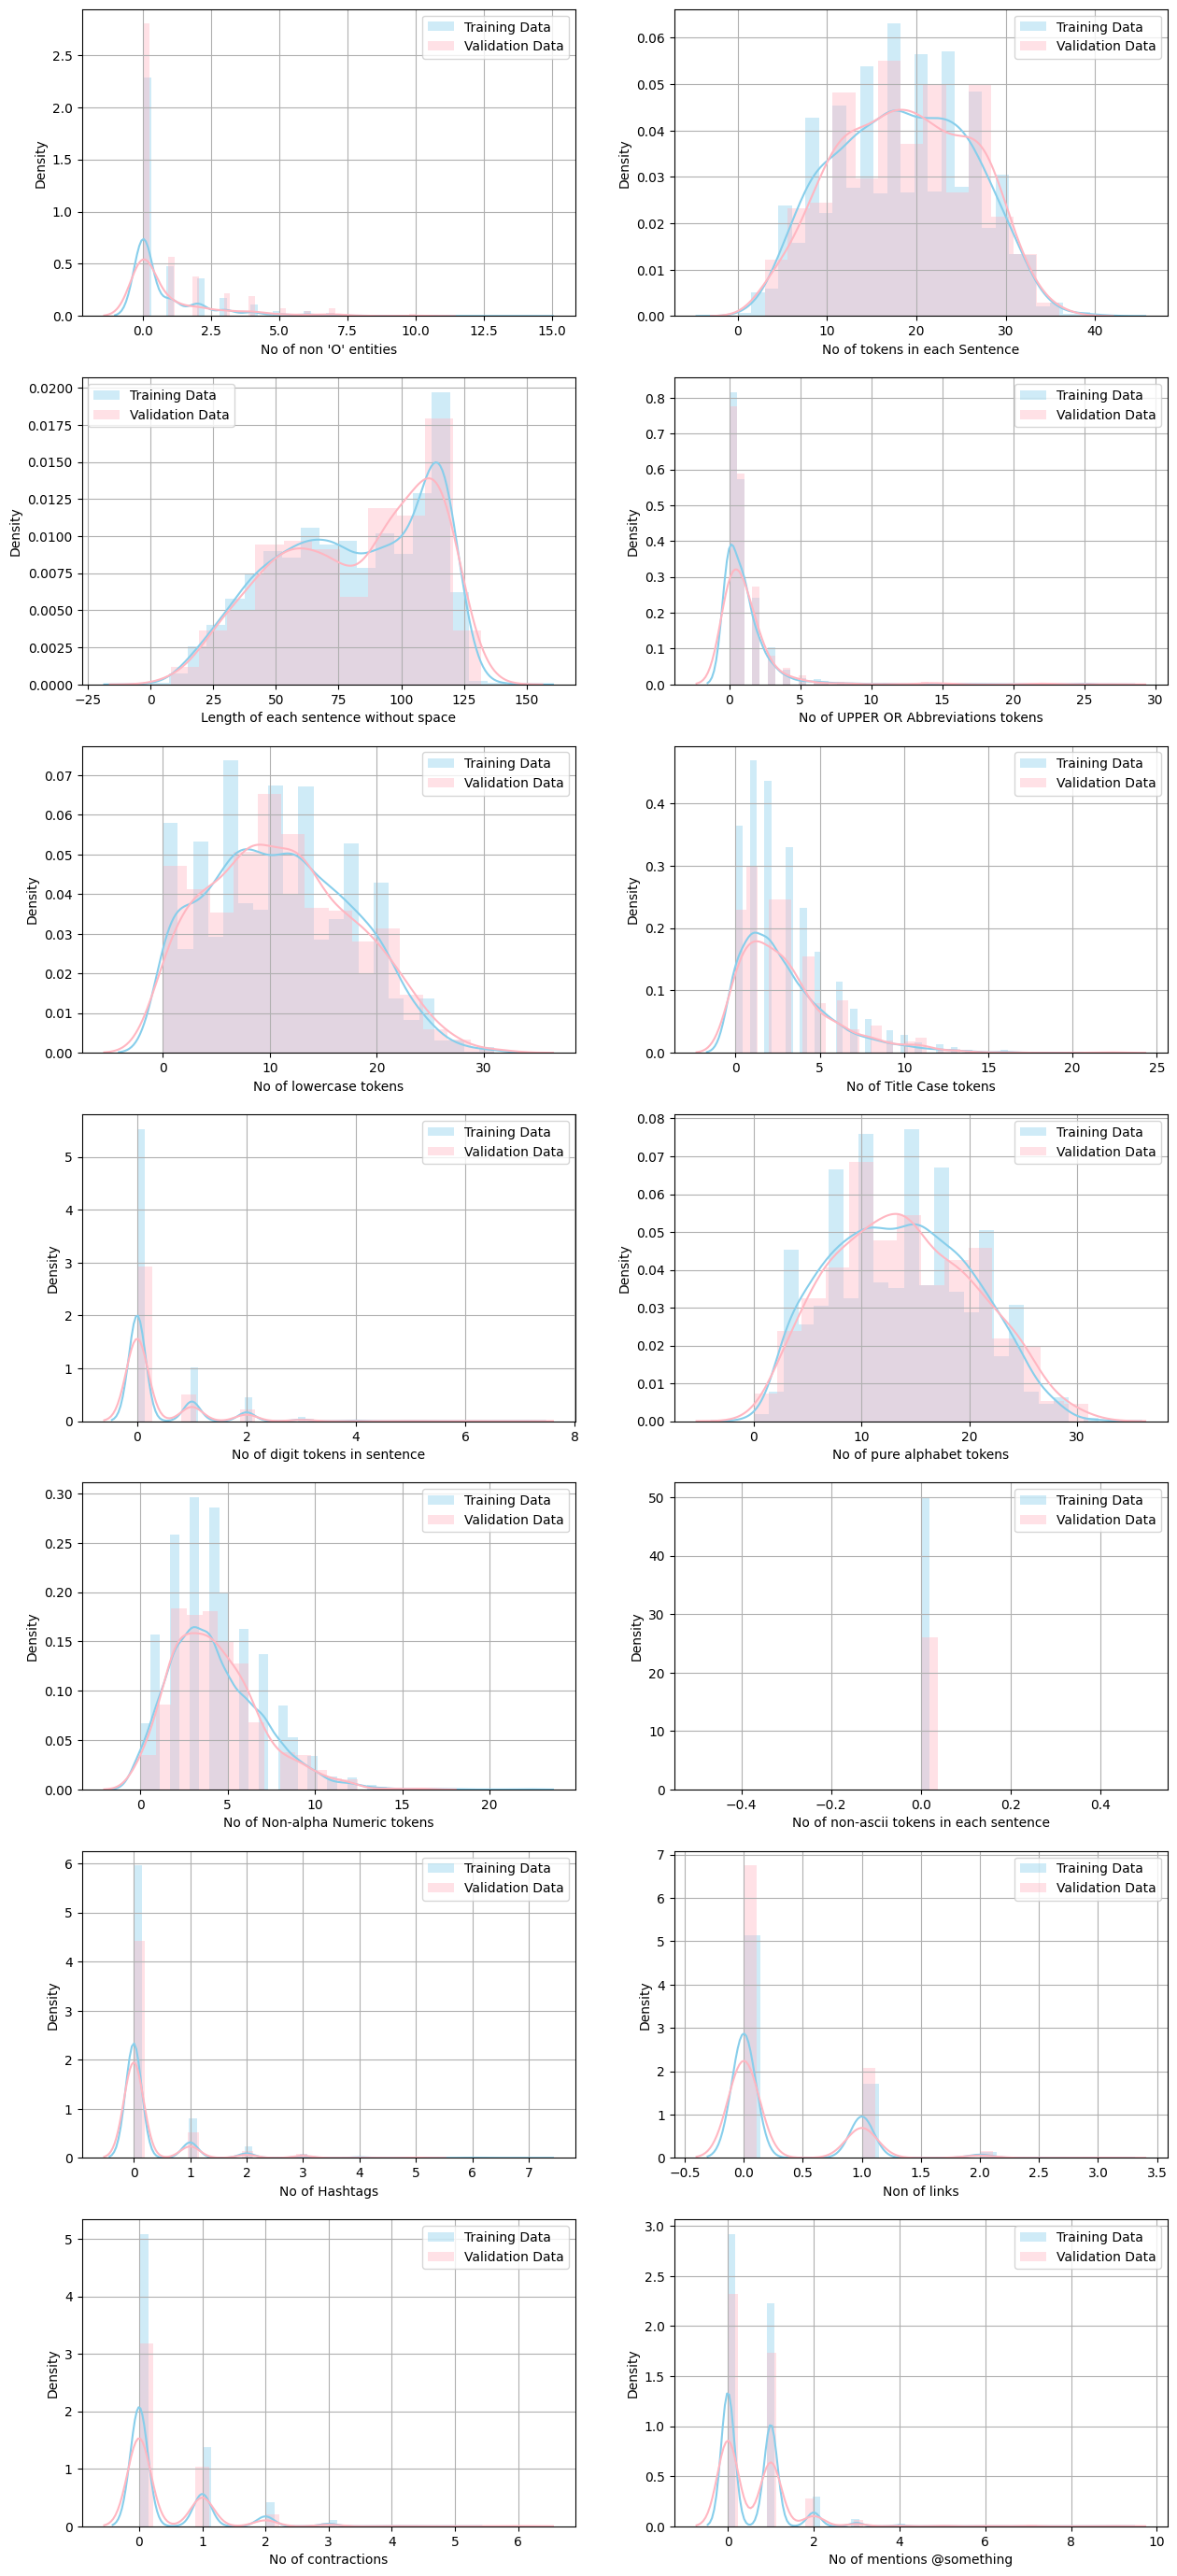

In [11]:
tot = len(TRAIN_SENT_EDA_INFO)
rows = (tot//2 if not tot%2 else (tot//2)+1)
cols = 2

f,ax = plt.subplots(rows,cols,figsize=(15,5*rows))
ax = ax.ravel()

sent_data = {"train":{}, "val":{}} # make Dataframe

for i, key in enumerate(TRAIN_SENT_EDA_INFO.keys()):

    train_data = list(TRAIN_SENT_EDA_INFO[key][0].values())
    val_data = list(VAL_SENT_EDA_INFO[key][0].values())

    sent_data["train"][key] = train_data
    sent_data["val"][key] = val_data


    x_label = TRAIN_SENT_EDA_INFO[key][1]

    ax[i] = sns.distplot(train_data,kde=True,ax=ax[i],color="#87ceeb",label='Training Data')
    ax[i] = sns.distplot(val_data,kde=True,ax=ax[i],color="#FFB6C1",label='Validation Data')

    ax[i].set_xlabel(x_label)
    ax[i].legend()
    ax[i].grid()

plt.plot()

## All the Sentence level Features

In [12]:
t_df = pd.DataFrame(sent_data["train"])
print((t_df["sent_ent_count"] == 0).sum() / t_df.shape[0], f"% sentences have 0 predictable entities in them")

t_desc = t_df.describe().T
t_desc["sum"] = t_df.sum().values
t_desc

0.6388070692194403 % sentences have 0 predictable entities in them


,count,mean,std,min,25%,50%,75%,max,sum
sent_ent_count,2716.0,0.917526,1.683363,0.0,0.0,0.0,1.0,14.0,2492
sent_tok_count,2716.0,18.420839,7.503320,0.0,13.0,18.0,24.0,41.0,50031
sent_len_count,2716.0,79.955081,30.082309,0.0,56.0,82.0,109.0,142.0,217158
sent_upper_count,2716.0,1.254050,2.472590,0.0,0.0,1.0,2.0,27.0,3406
sent_lower_count,2716.0,10.992636,6.642013,0.0,6.0,11.0,16.0,31.0,29856
sent_title_count,2716.0,2.955817,2.740374,0.0,1.0,2.0,4.0,20.0,8028
sent_number_count,2716.0,0.339102,0.749386,0.0,0.0,0.0,0.0,7.0,921
sent_alpha_count,2716.0,13.667158,6.357464,0.0,9.0,14.0,19.0,32.0,37120
sent_non_alphanum_count,2716.0,4.283505,2.649695,0.0,2.0,4.0,6.0,22.0,11634
sent_non_ascii_count,2716.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [13]:
v_desc = pd.DataFrame(sent_data["val"]).describe().T
v_desc["sum"] = pd.DataFrame(sent_data["val"]).sum().values
v_desc

,count,mean,std,min,25%,50%,75%,max,sum
sent_ent_count,679.0,0.983800,1.763620,0.0,0.0,0.0,1.0,10.0,668
sent_tok_count,679.0,18.702504,7.388094,3.0,13.0,19.0,25.0,36.0,12699
sent_len_count,679.0,81.371134,29.871664,8.0,57.0,87.0,108.5,132.0,55251
sent_upper_count,679.0,1.372607,2.831744,0.0,0.0,1.0,2.0,27.0,932
sent_lower_count,679.0,11.123711,6.724631,0.0,6.0,11.0,16.0,31.0,7553
sent_title_count,679.0,3.026510,2.835594,0.0,1.0,2.0,4.0,22.0,2055
sent_number_count,679.0,0.321060,0.740733,0.0,0.0,0.0,0.0,7.0,218
sent_alpha_count,679.0,13.955817,6.523237,0.0,9.0,14.0,19.0,31.0,9476
sent_non_alphanum_count,679.0,4.273932,2.537927,0.0,2.0,4.0,6.0,16.0,2902
sent_non_ascii_count,679.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0


# Entity & Word Level EDA

In [14]:
for ent_name, dist in train_eda.entity_len.items():
    print(f"Minimum, Average, Median and Max Token length for '{ent_name}' Tag is {min(dist)}, {round(np.mean(dist), 3)}, {round(np.median(dist), 3)} and {max(dist)} respctively")


print("-"*50)

for ent_name, dist in build_parent_level_dict(train_eda.entity_len).items():
    print(f"Minimum, Average, Median and Max Token length for '{ent_name}' Tag is {min(dist)}, {round(np.mean(dist), 3)}, {round(np.median(dist), 3)} and {max(dist)} respctively")


Minimum, Average, Median and Max Token length for 'O' Tag is 1, 4.285, 3.0 and 121 respctively
Minimum, Average, Median and Max Token length for 'B-person' Tag is 1, 5.322, 5.0 and 15 respctively
Minimum, Average, Median and Max Token length for 'B-location' Tag is 1, 5.771, 6.0 and 14 respctively
Minimum, Average, Median and Max Token length for 'I-location' Tag is 1, 5.095, 5.0 and 11 respctively
Minimum, Average, Median and Max Token length for 'B-creative-work' Tag is 1, 5.812, 6.0 and 13 respctively
Minimum, Average, Median and Max Token length for 'B-group' Tag is 1, 5.526, 5.0 and 25 respctively
Minimum, Average, Median and Max Token length for 'I-group' Tag is 1, 5.164, 5.0 and 12 respctively
Minimum, Average, Median and Max Token length for 'B-corporation' Tag is 2, 6.13, 7.0 and 10 respctively
Minimum, Average, Median and Max Token length for 'I-creative-work' Tag is 1, 4.254, 4.0 and 10 respctively
Minimum, Average, Median and Max Token length for 'I-corporation' Tag is 2, 5

## A huge thrrough list of granular features to check and sift through

In [15]:
for feat_name, val in train_eda.create_entity_df().items():
    print(f"Total Count of {feat_name}: {val}")

Total Count of title_B-location: 313
Total Count of title_I-location: 152
Total Count of title_B-creative-work: 93
Total Count of title_B-person: 403
Total Count of title_B-group: 133
Total Count of title_I-group: 86
Total Count of title_I-creative-work: 109
Total Count of title_B-corporation: 95
Total Count of title_I-corporation: 29
Total Count of title_I-person: 213
Total Count of title_B-product: 61
Total Count of title_I-product: 72
Total Count of title_location: 72
Total Count of title_creative-work: 72
Total Count of title_person: 72
Total Count of title_group: 72
Total Count of title_corporation: 72
Total Count of title_product: 72
Total Count of lower_B-person: 70
Total Count of lower_I-location: 28
Total Count of lower_B-corporation: 44
Total Count of lower_B-group: 11
Total Count of lower_I-creative-work: 44
Total Count of lower_B-location: 38
Total Count of lower_B-creative-work: 13
Total Count of lower_I-group: 22
Total Count of lower_I-product: 30
Total Count of lower_B-p

# Some Helps and Ideas can be used from 

In [16]:
# !pip install gingerit
# !https://pypi.org/project/tweet-preprocessor/
# https://blog.devgenius.io/preprocessing-twitter-dataset-using-nltk-approach-1beb9a338cc1
# https://github.com/mit-ccc/TweebankNLP/tree/main